In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import (retrieve_feature_names, plot_feature_importances, plot_confusion_matrix)
    
pd.set_option('display.max_columns', 300) 

In [8]:
bl_df = pd.read_csv('processed_data/bl_df.csv')

In [9]:
X = bl_df.drop(columns=['DX_6M', 'DX_12M', 'DX_24M', 'DX_48M', 'DX_60M'])  
y = bl_df[['DX_6M', 'DX_12M', 'DX_24M', 'DX_48M', 'DX_60M']] 

y_encoded = y.copy()
label_encoders = {}
for col in y_encoded.columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y_encoded[col])
    label_encoders[col] = le

    
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [10]:
numeric_features = ['AGE', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'PTAU', 'ADAS11', 'ADAS13', 'RAVLT_immediate', 'RAVLT_learning',
                    'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 
                    'EcogPtLang', 'EcogPtVisspat', 'EcogPtTotal', 'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 
                    'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'mPACCdigit', 'mPACCtrailsB', 'EcogPtOrgan', 'EcogSPMem', 'EcogSPLang',
                    'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogPtPlan', 'EcogPtDivatt', 'EcogSPDivatt',]

categorical_features = ['SITE', 'APOE4', 'PTEDUCAT', 'CDRSB', 'MMSE', 
                        'COLPROT', 'ORIGPROT', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FLDSTRENG', 'FSVERSION']

DX_6M
              precision    recall  f1-score   support

          CN       0.96      0.98      0.97        92
    Dementia       0.00      0.00      0.00        10
DidNotAttend       1.00      0.60      0.75        10
         MCI       0.91      0.99      0.94       137

    accuracy                           0.93       249
   macro avg       0.72      0.64      0.67       249
weighted avg       0.89      0.93      0.91       249

DX_12M
              precision    recall  f1-score   support

          CN       0.92      0.92      0.92        83
    Dementia       0.43      0.35      0.39        17
DidNotAttend       0.53      0.36      0.43        25
         MCI       0.86      0.94      0.90       124

    accuracy                           0.83       249
   macro avg       0.68      0.64      0.66       249
weighted avg       0.82      0.83      0.82       249

DX_24M
              precision    recall  f1-score   support

          CN       0.85      0.96      0.90        81
 

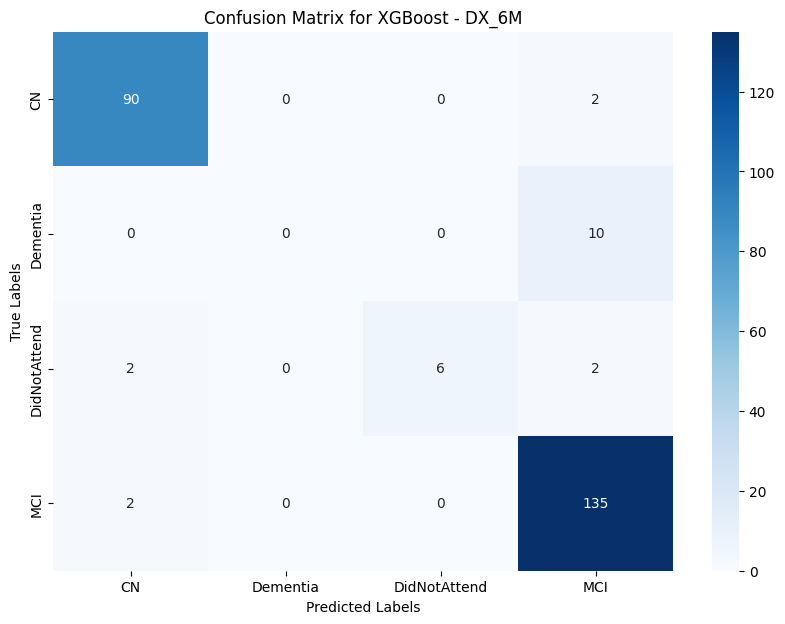

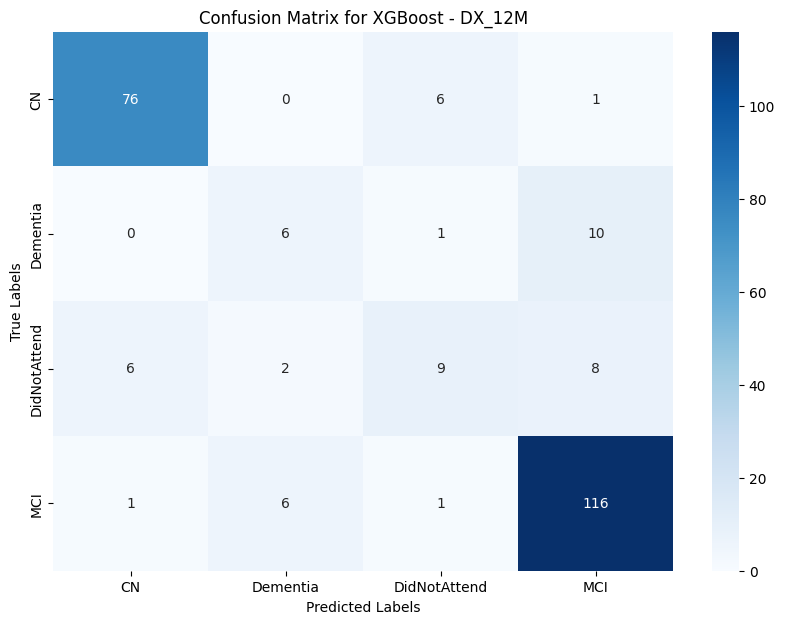

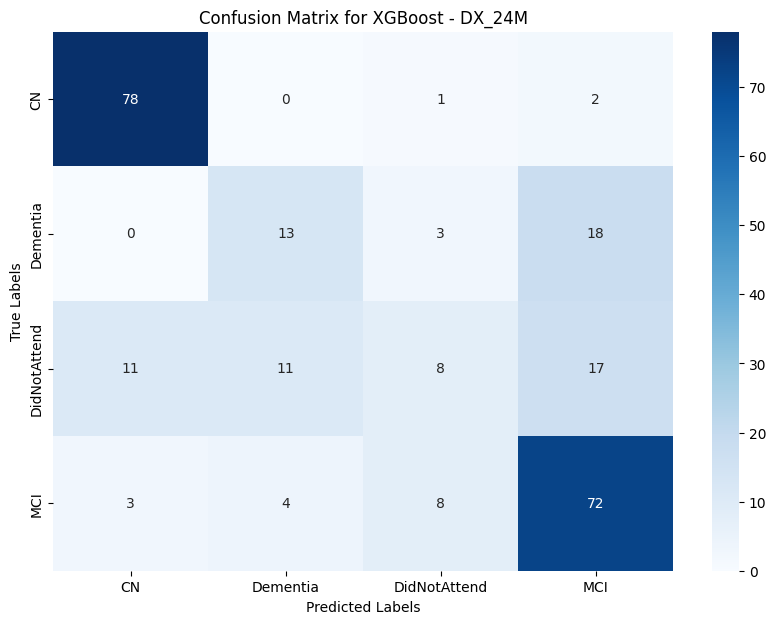

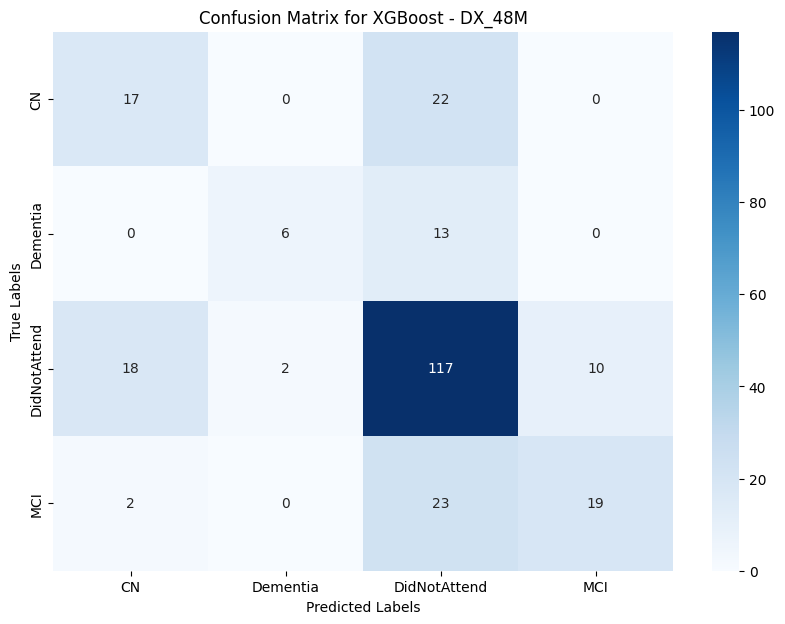

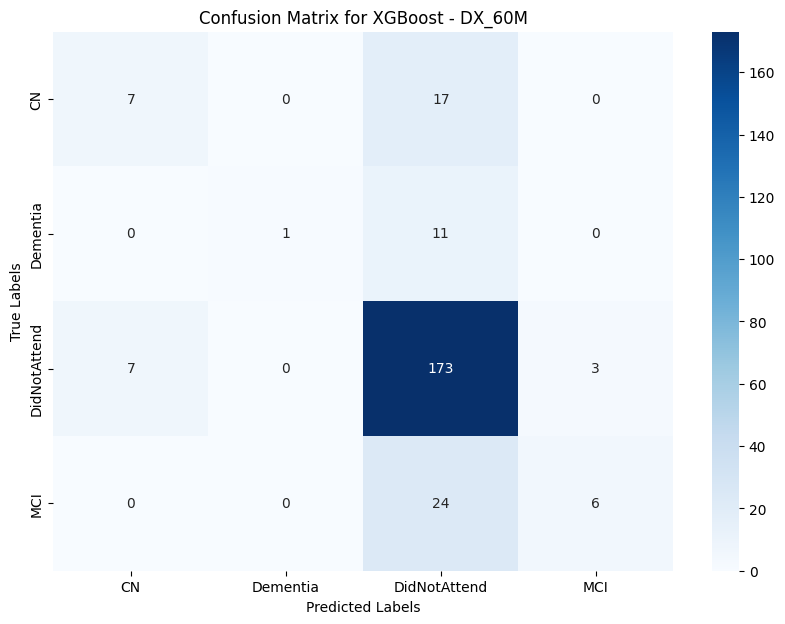

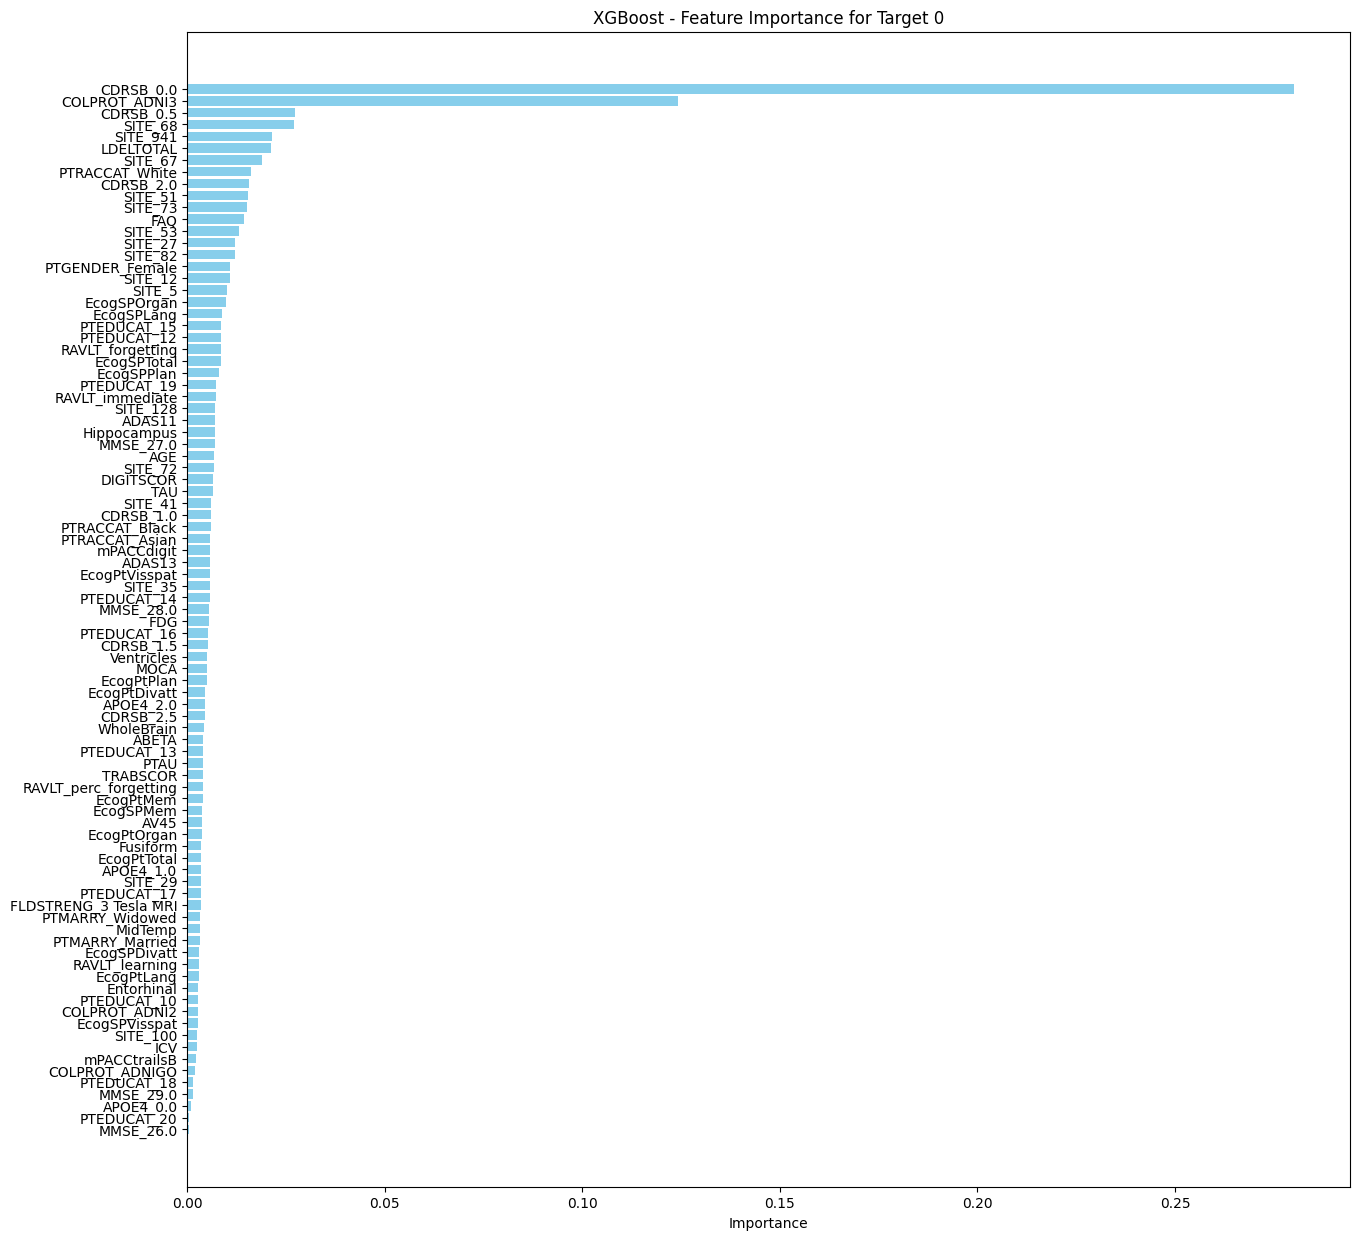

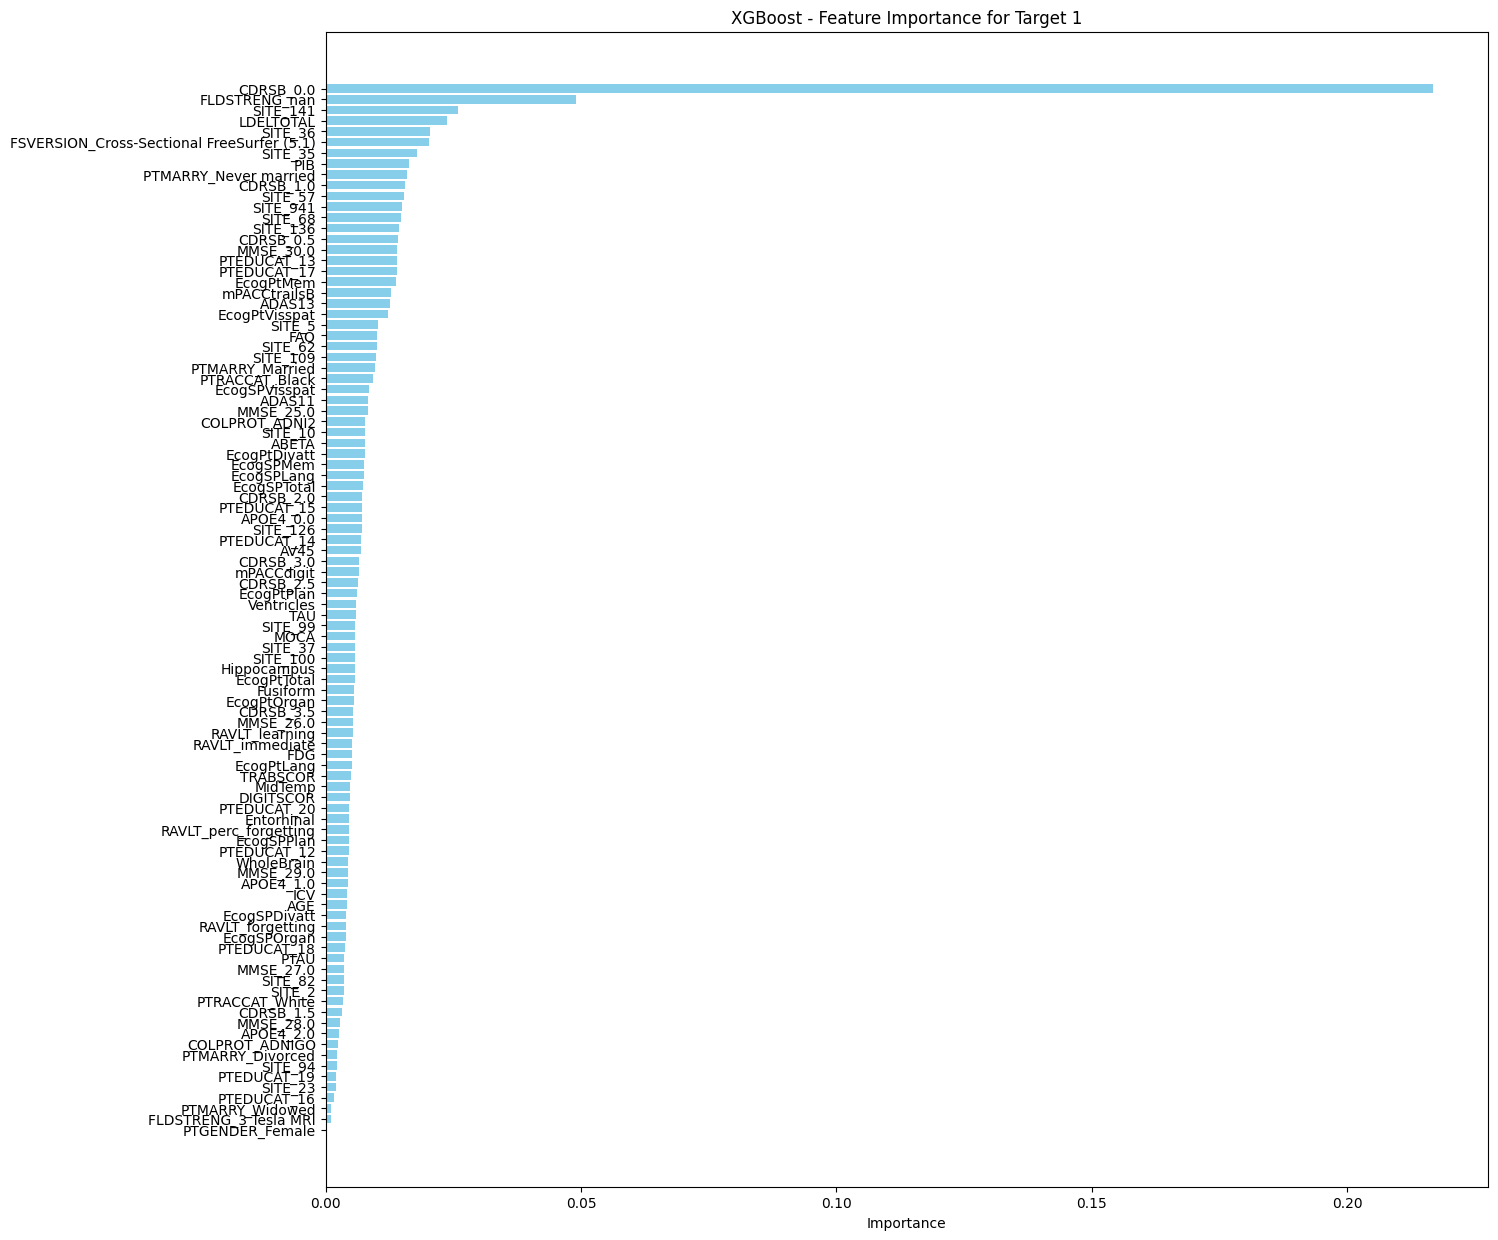

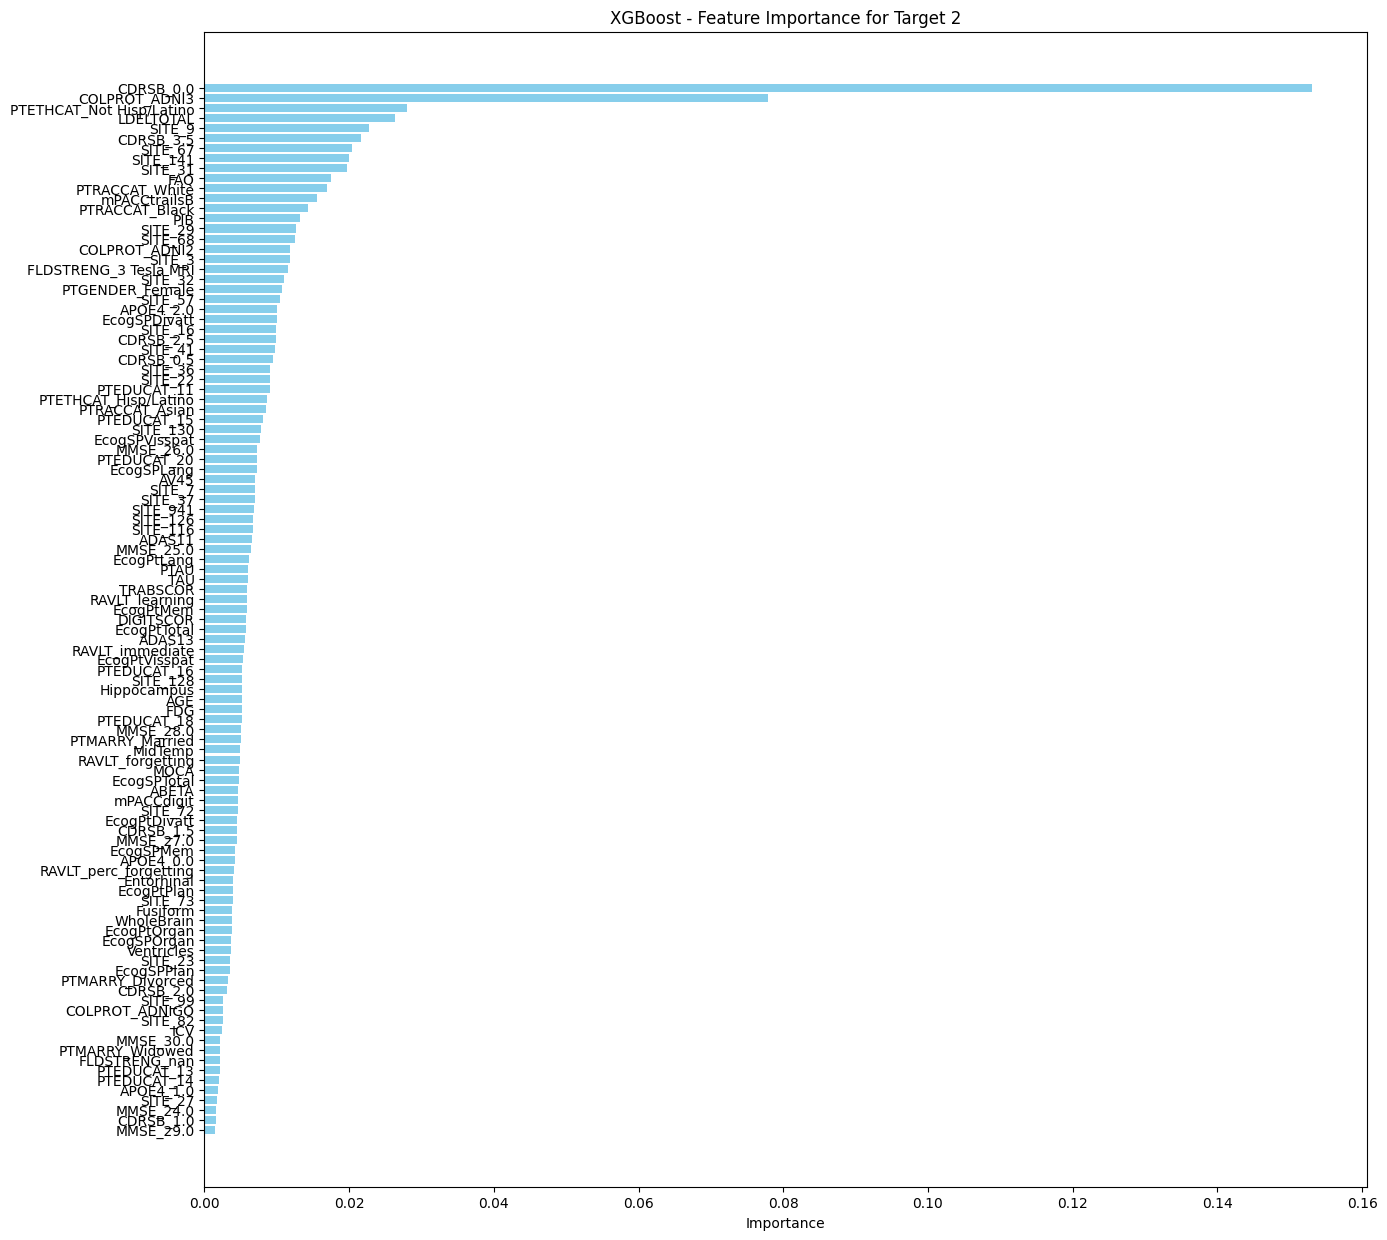

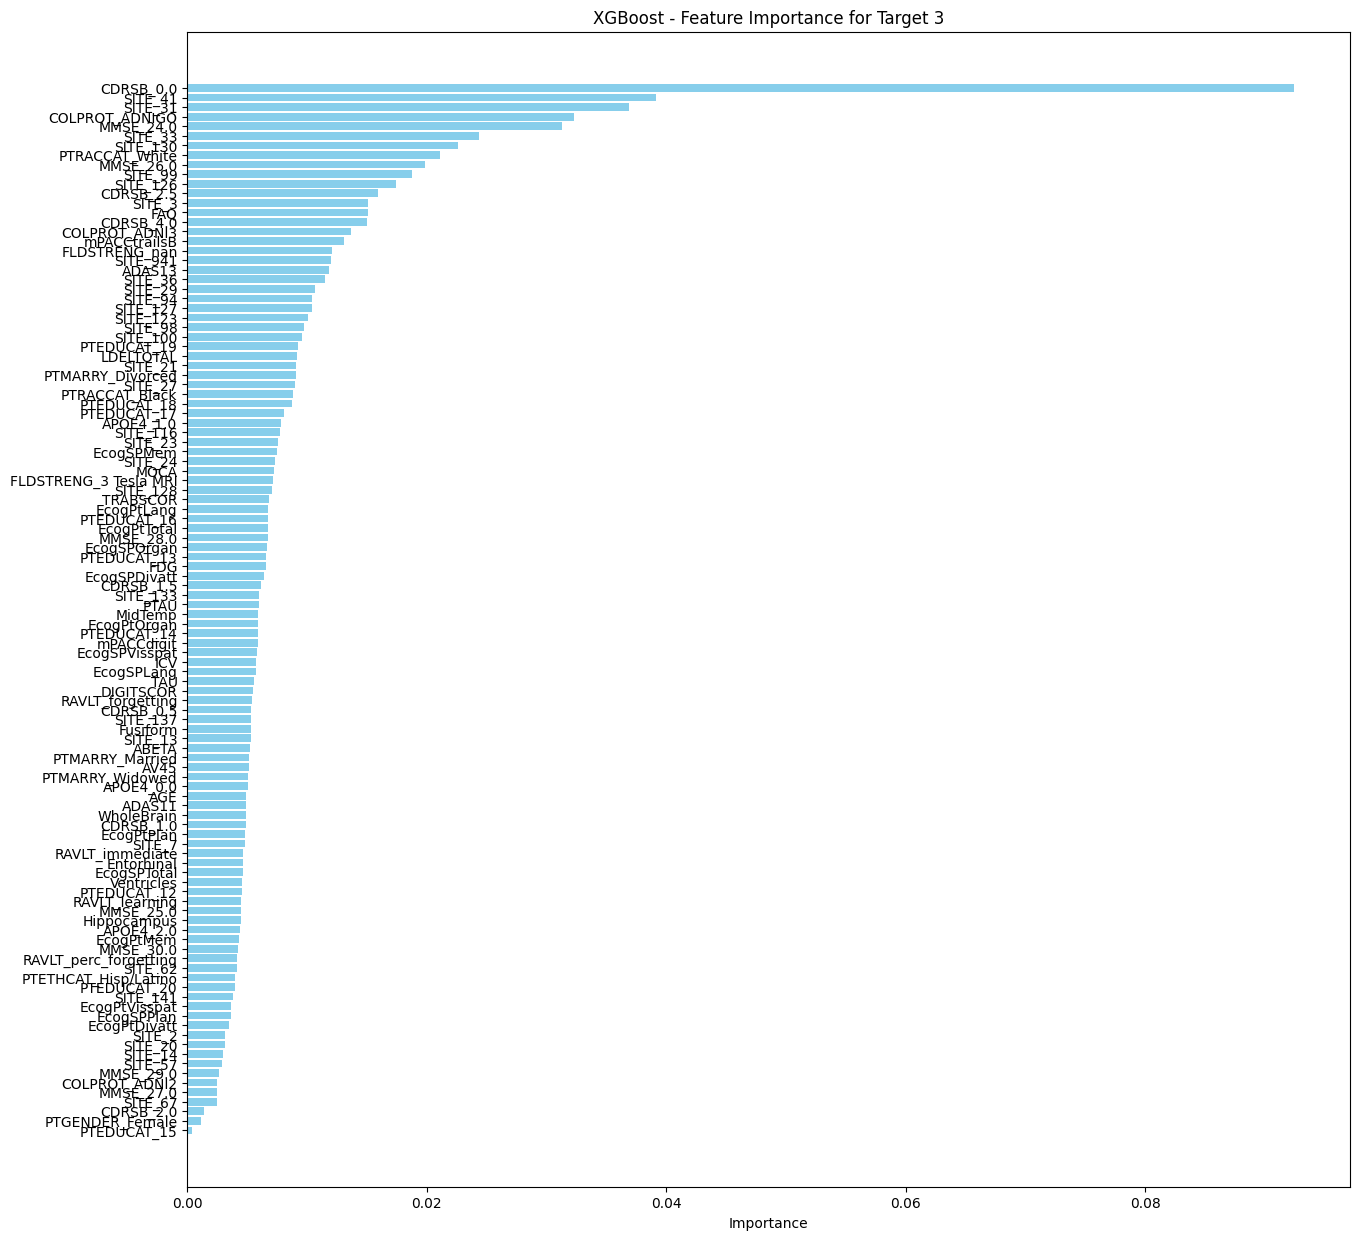

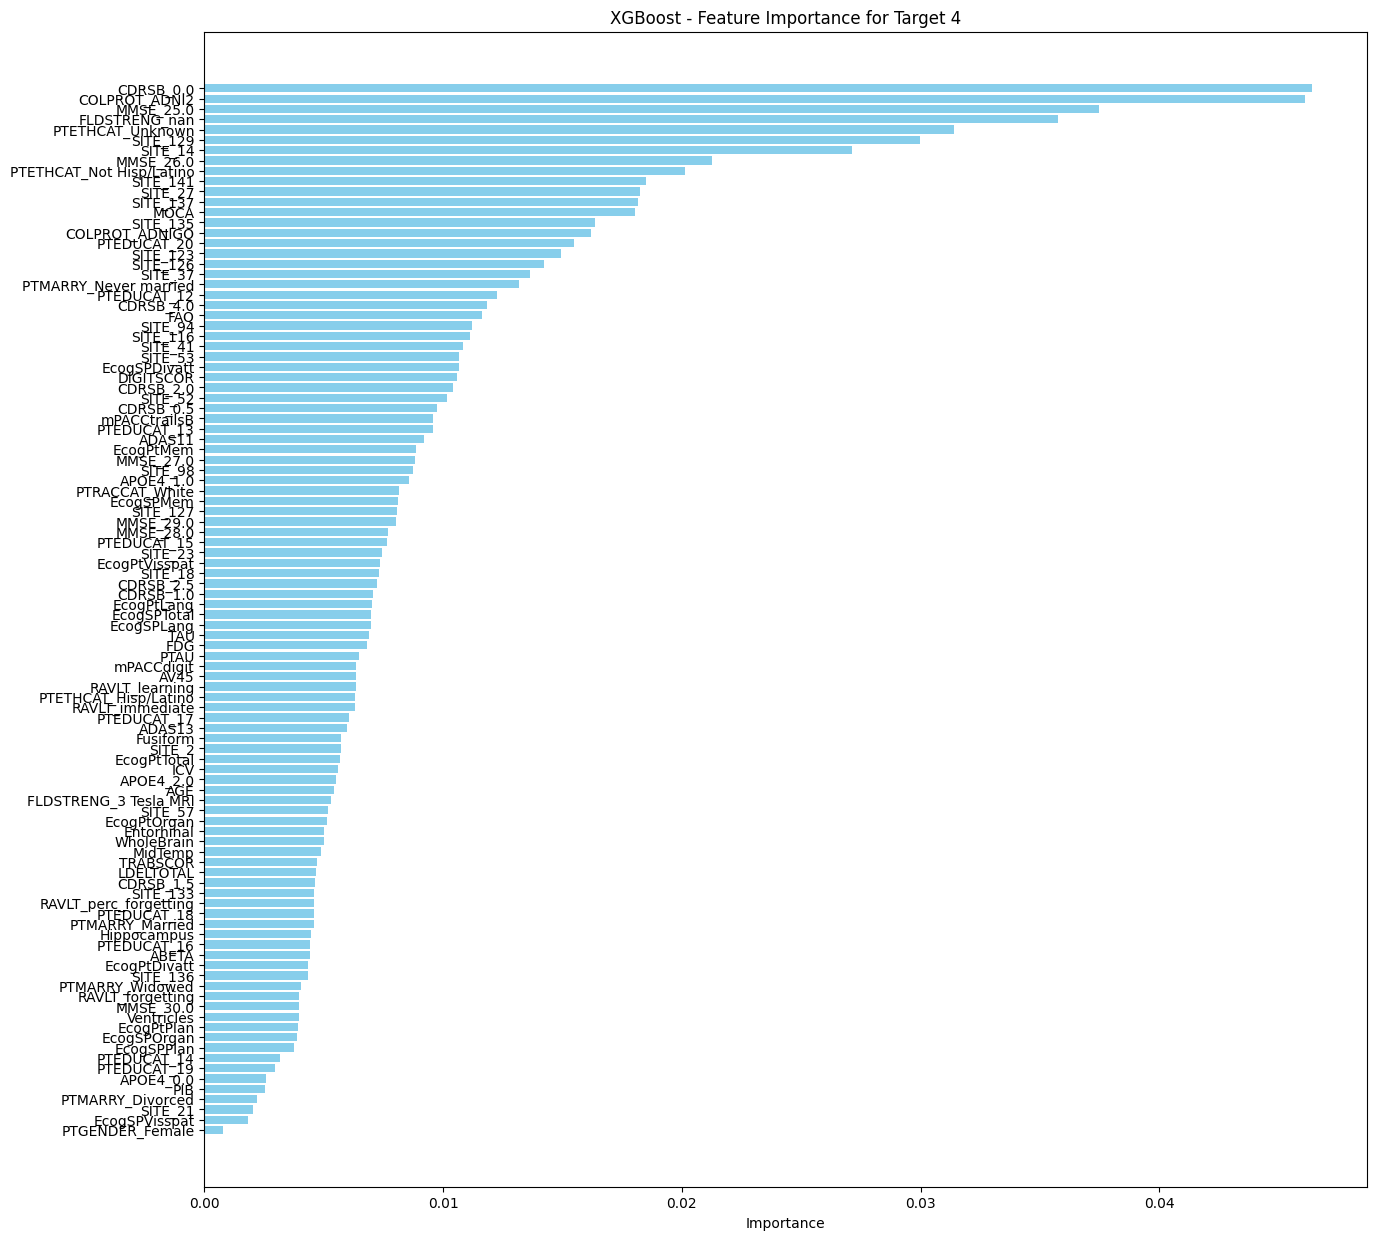

DX_6M
              precision    recall  f1-score   support

          CN       0.96      0.97      0.96        92
    Dementia       0.00      0.00      0.00        10
DidNotAttend       1.00      0.60      0.75        10
         MCI       0.90      0.99      0.94       137

    accuracy                           0.92       249
   macro avg       0.71      0.64      0.66       249
weighted avg       0.89      0.92      0.90       249

DX_12M
              precision    recall  f1-score   support

          CN       0.93      0.93      0.93        83
    Dementia       0.50      0.35      0.41        17
DidNotAttend       0.60      0.36      0.45        25
         MCI       0.85      0.95      0.90       124

    accuracy                           0.84       249
   macro avg       0.72      0.65      0.67       249
weighted avg       0.83      0.84      0.83       249

DX_24M
              precision    recall  f1-score   support

          CN       0.84      0.99      0.91        81
 

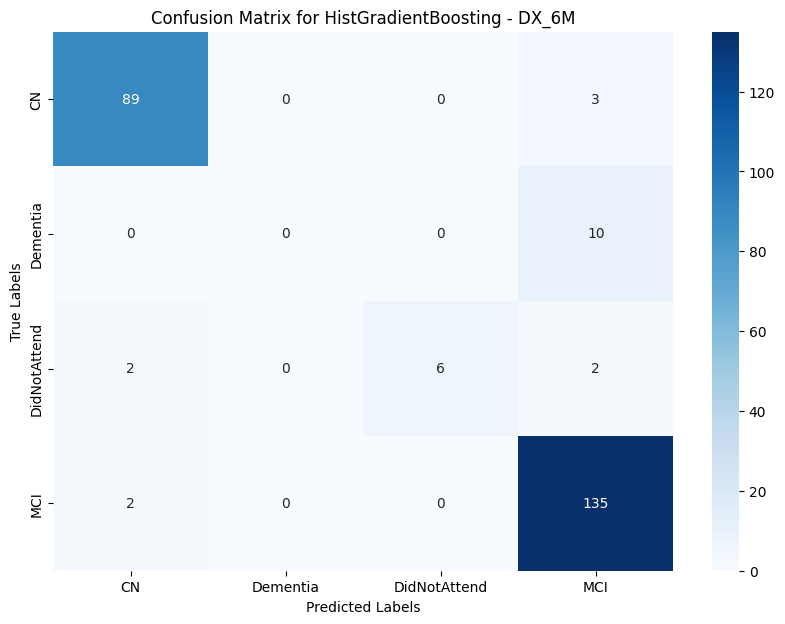

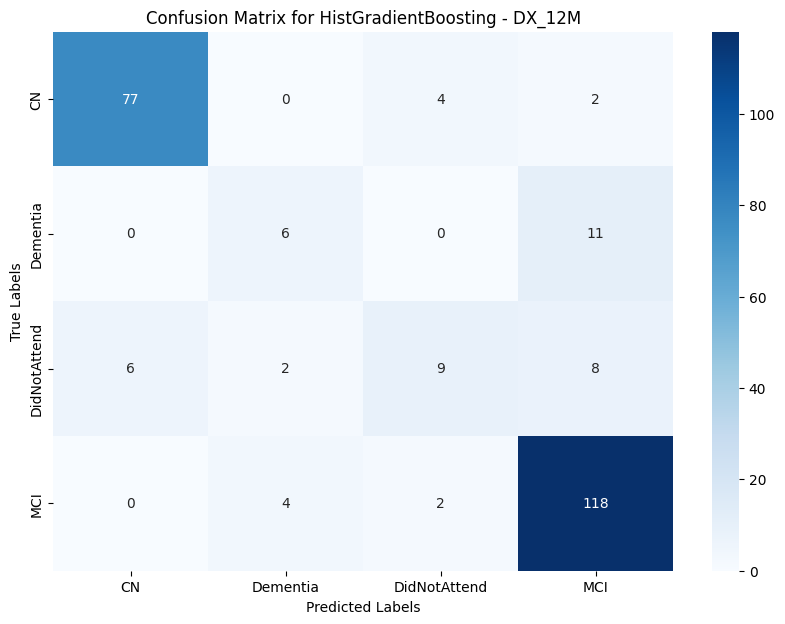

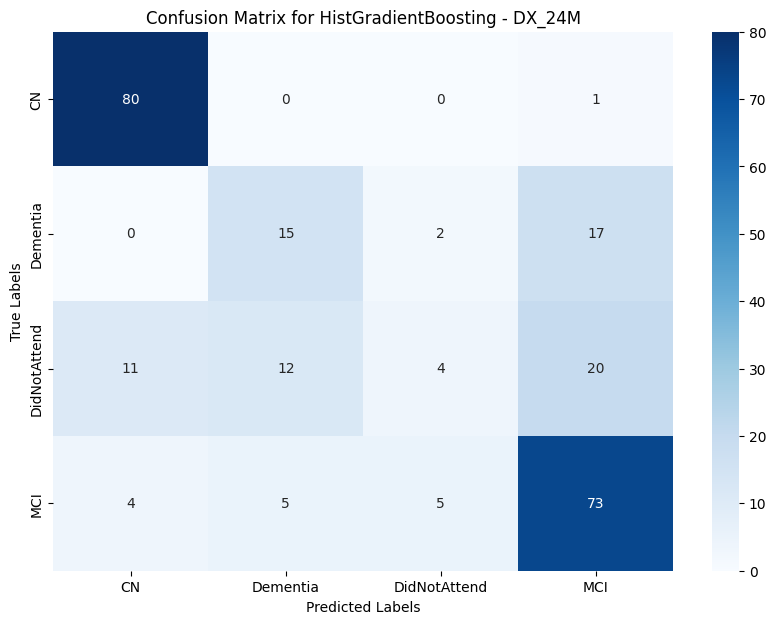

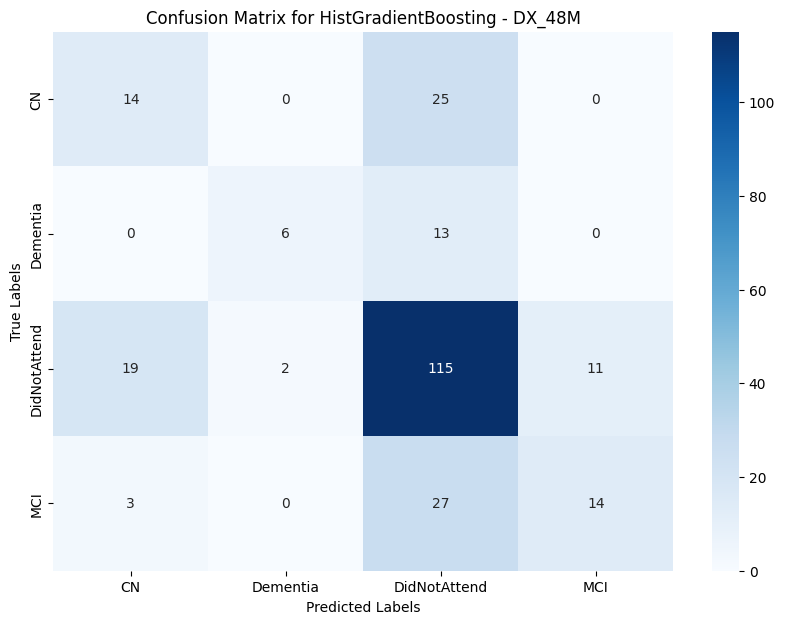

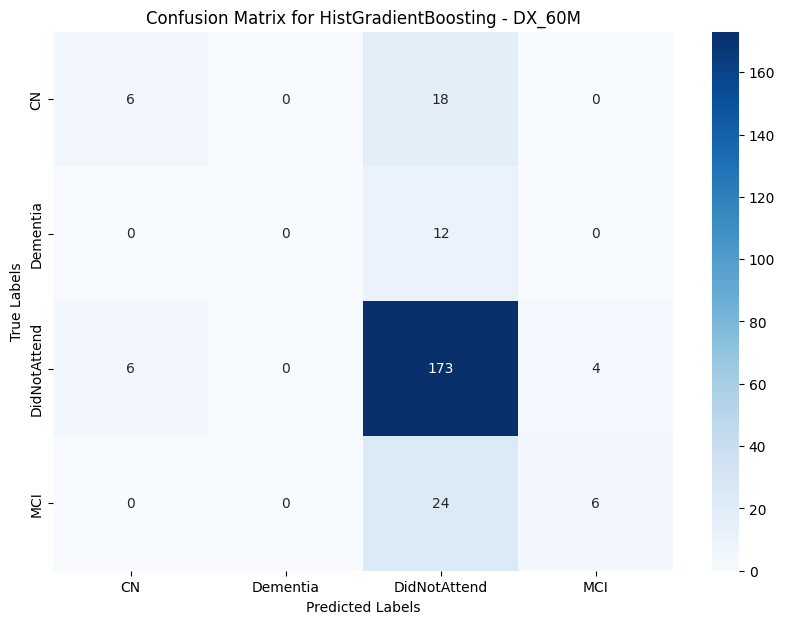

No feature importances for HistGradientBoosting - Target 0
No feature importances for HistGradientBoosting - Target 1
No feature importances for HistGradientBoosting - Target 2
No feature importances for HistGradientBoosting - Target 3
No feature importances for HistGradientBoosting - Target 4
DX_6M
              precision    recall  f1-score   support

          CN       0.96      0.98      0.97        92
    Dementia       0.00      0.00      0.00        10
DidNotAttend       1.00      0.60      0.75        10
         MCI       0.91      0.99      0.94       137

    accuracy                           0.93       249
   macro avg       0.72      0.64      0.67       249
weighted avg       0.89      0.93      0.91       249

DX_12M
              precision    recall  f1-score   support

          CN       0.93      0.94      0.93        83
    Dementia       0.60      0.35      0.44        17
DidNotAttend       0.67      0.40      0.50        25
         MCI       0.85      0.96      0

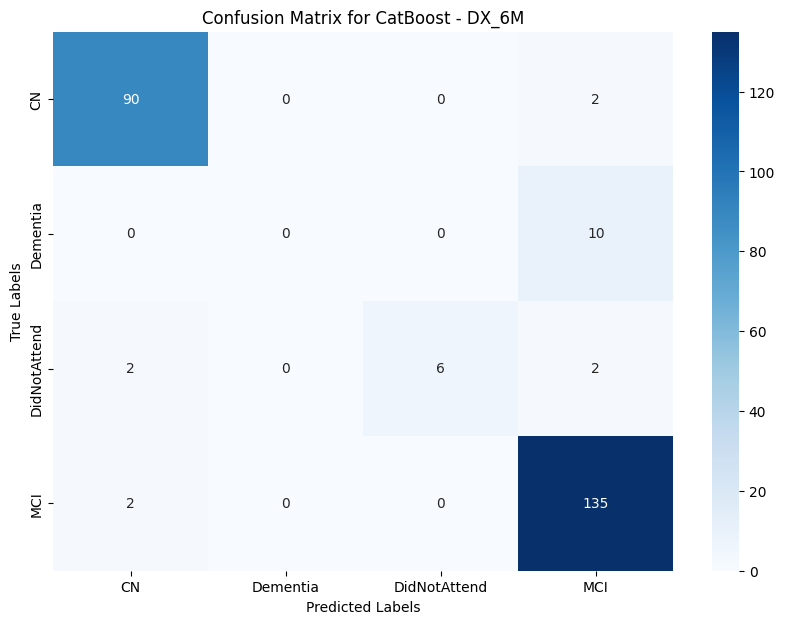

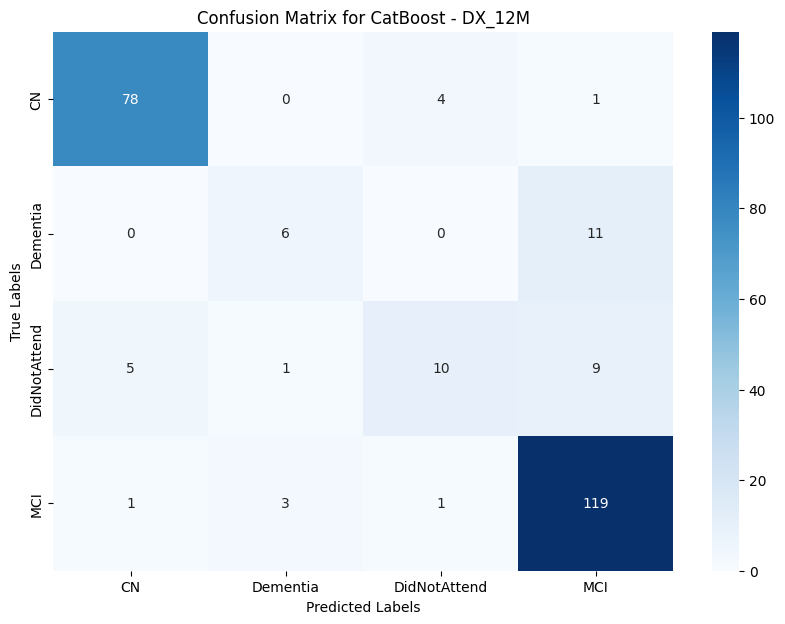

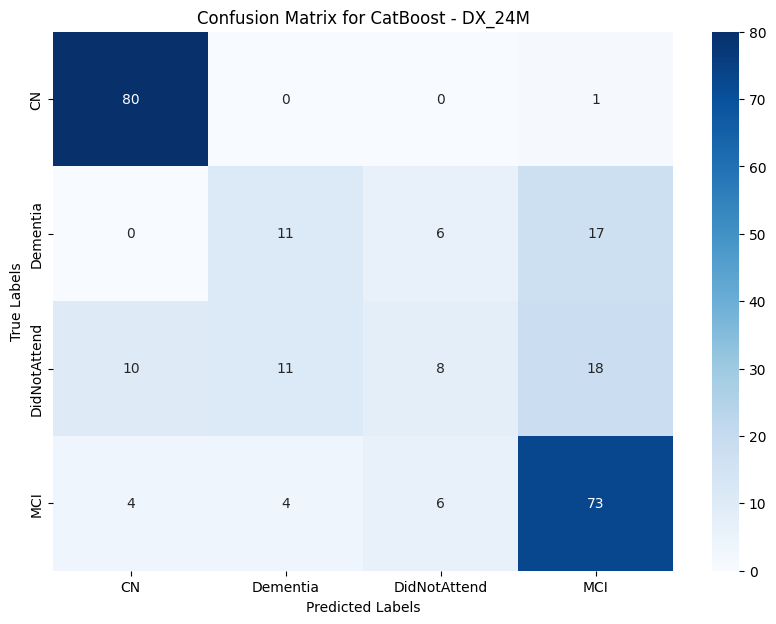

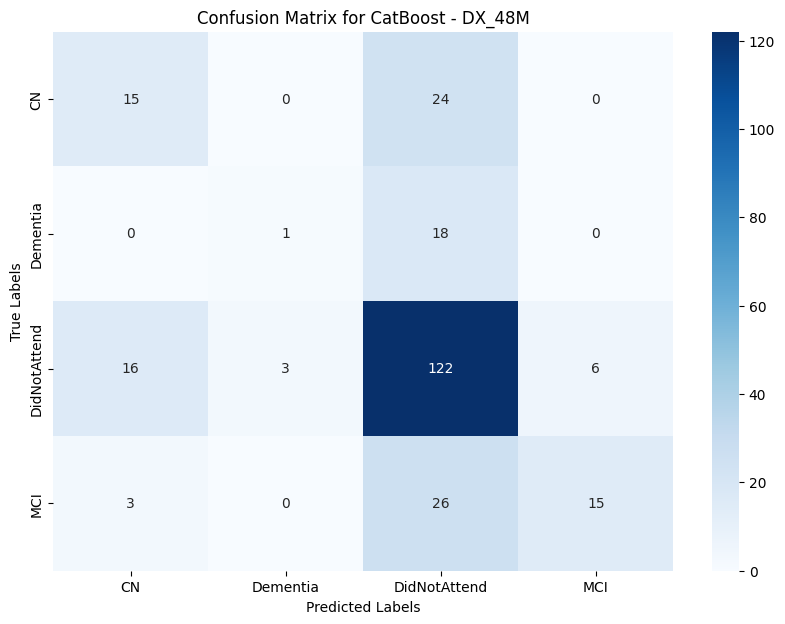

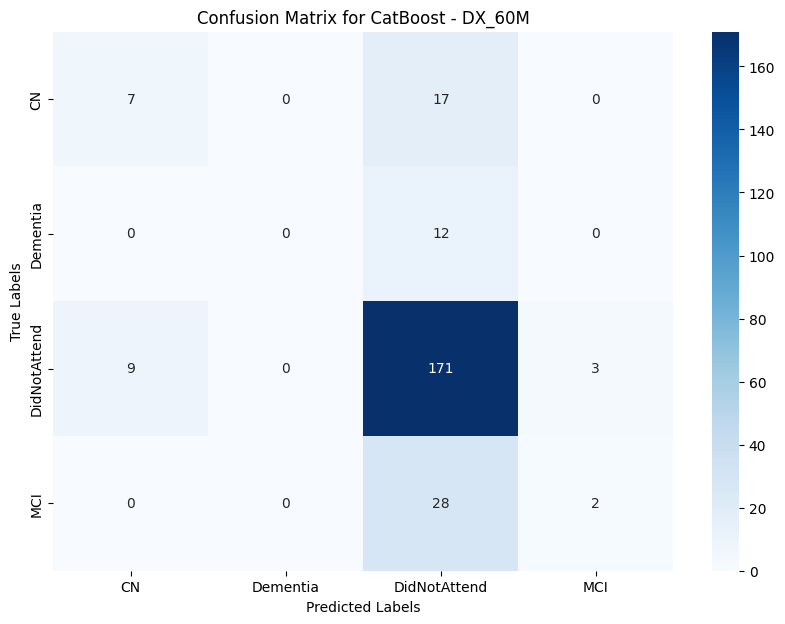

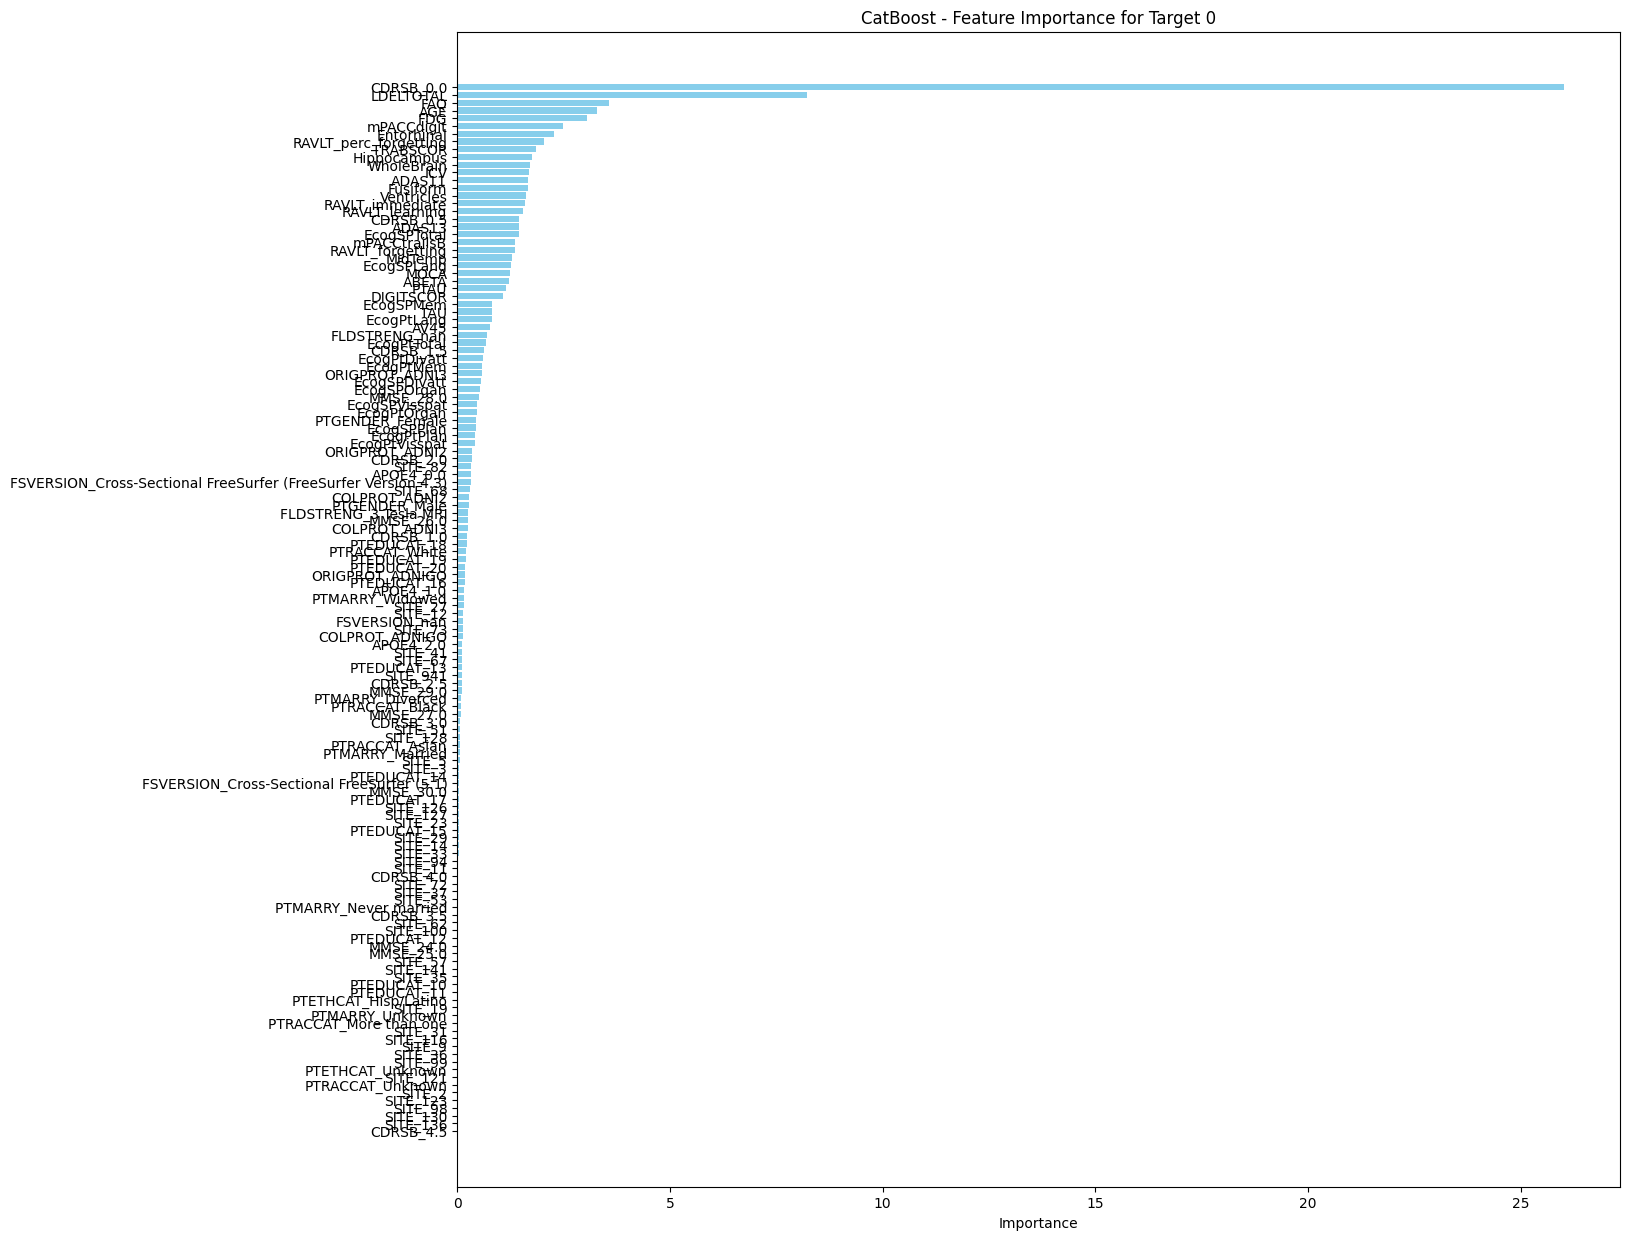

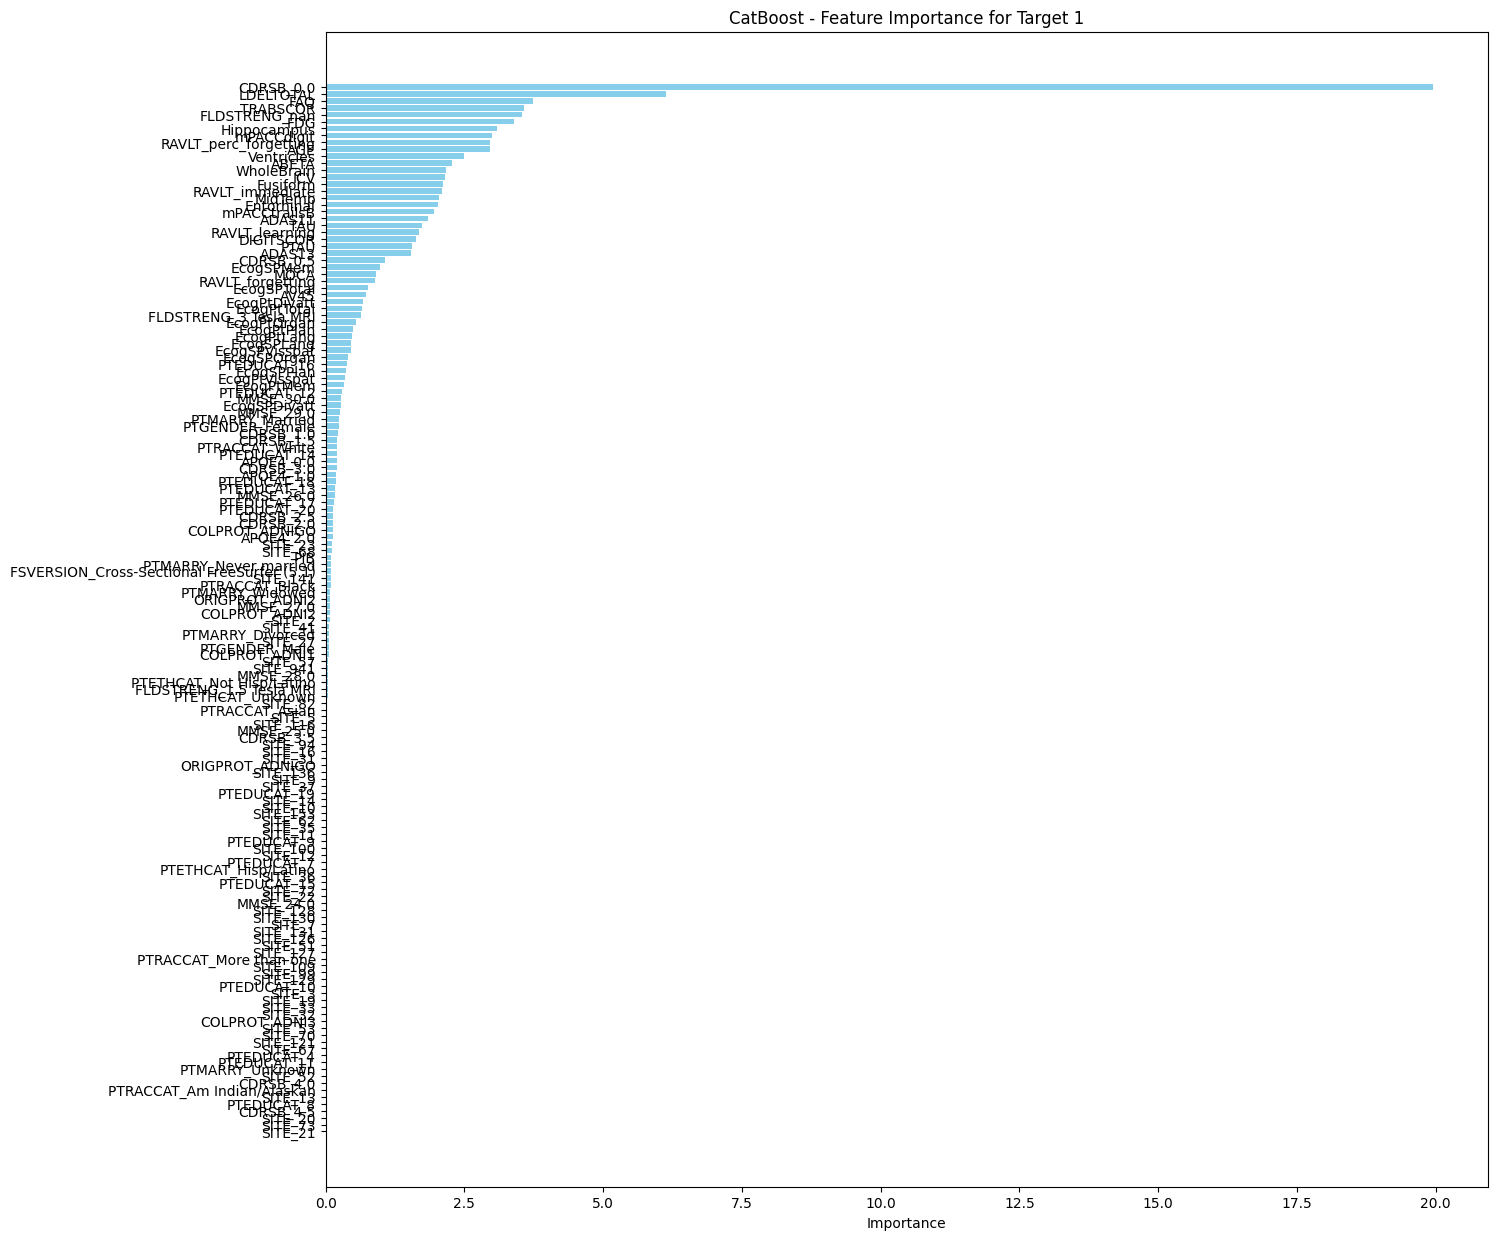

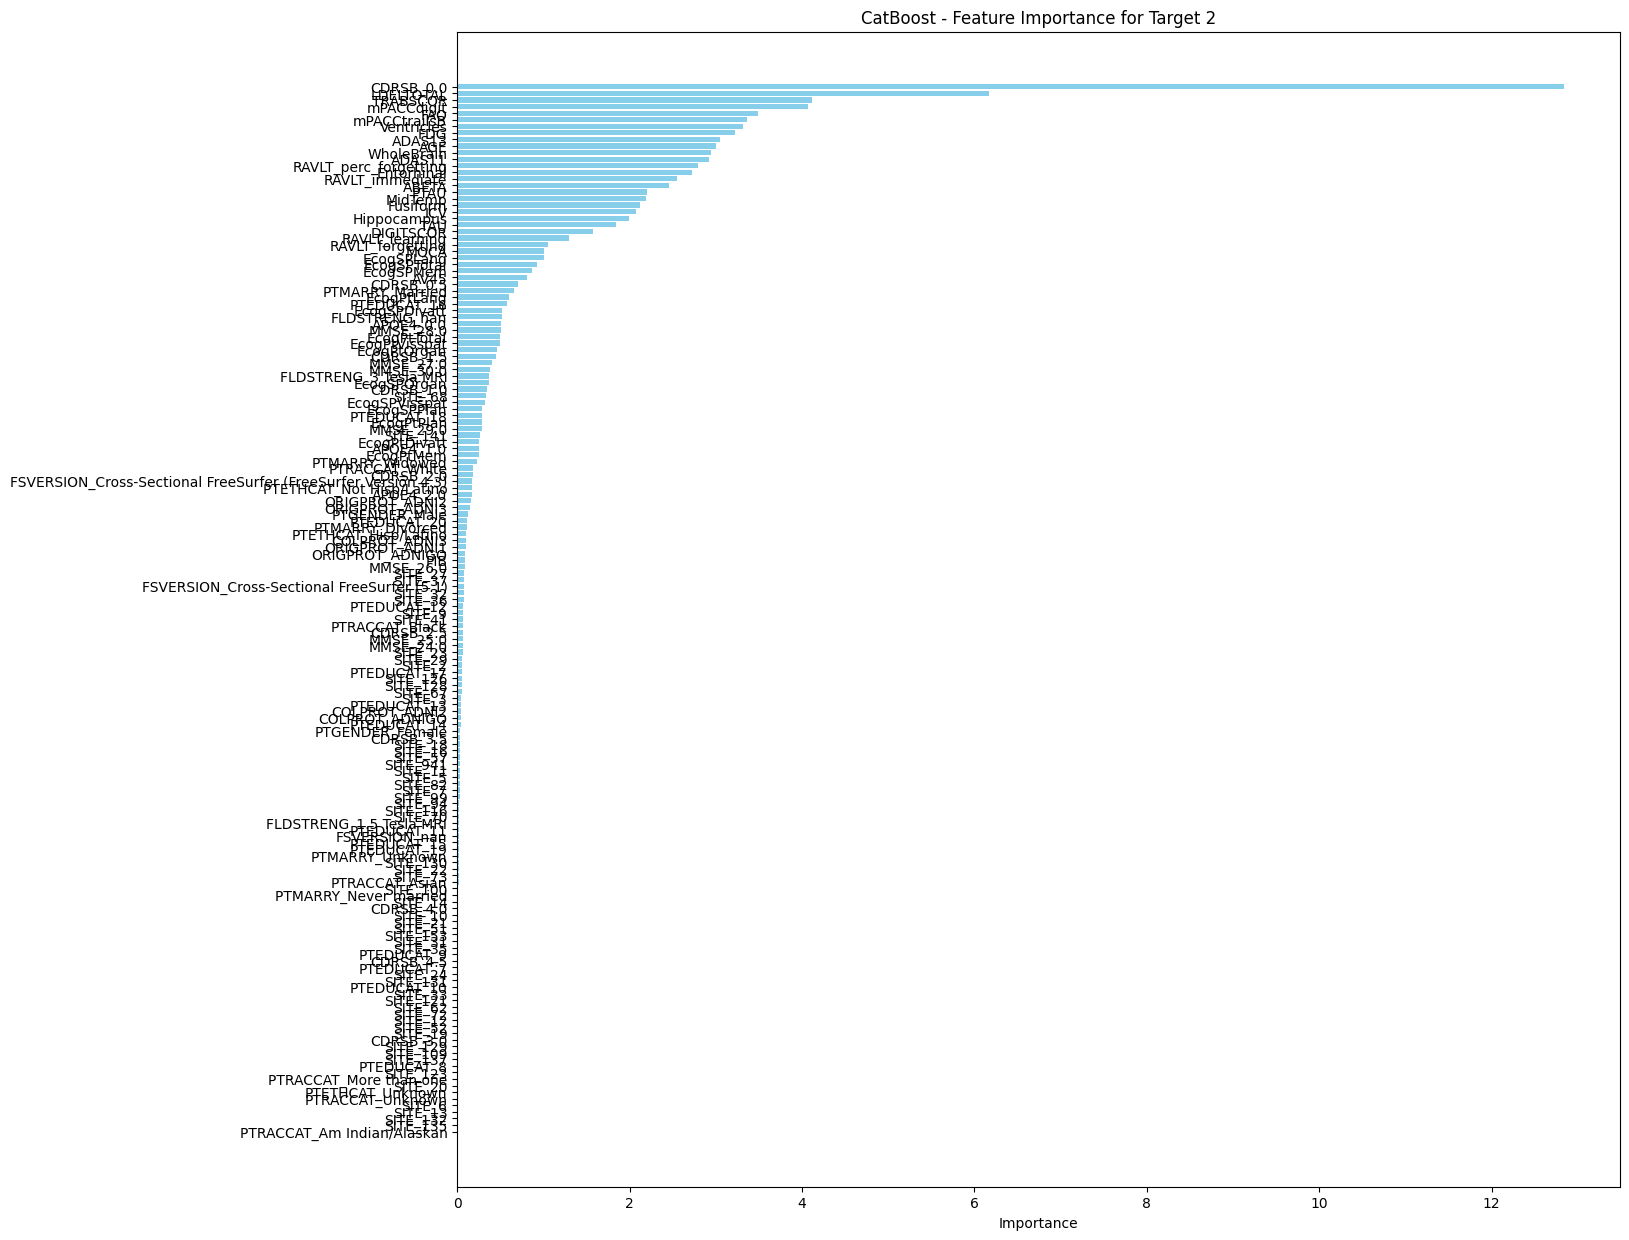

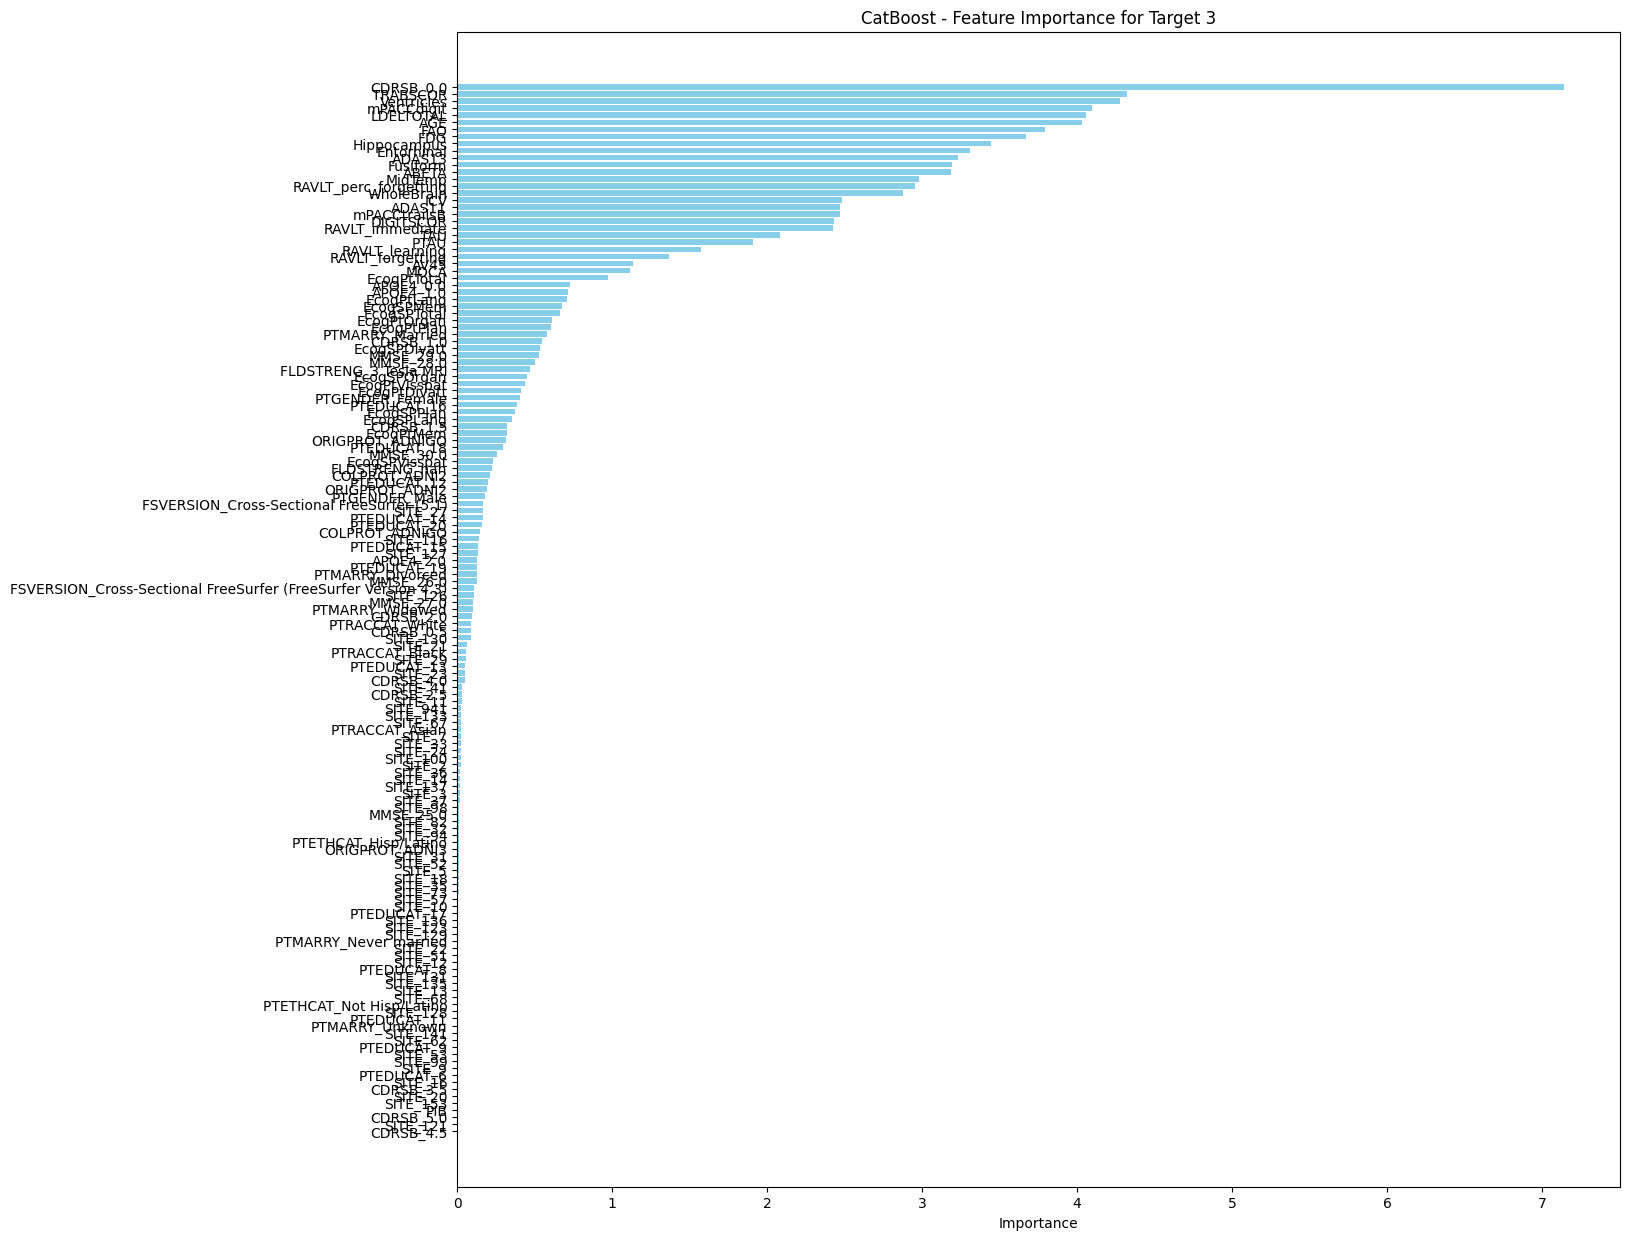

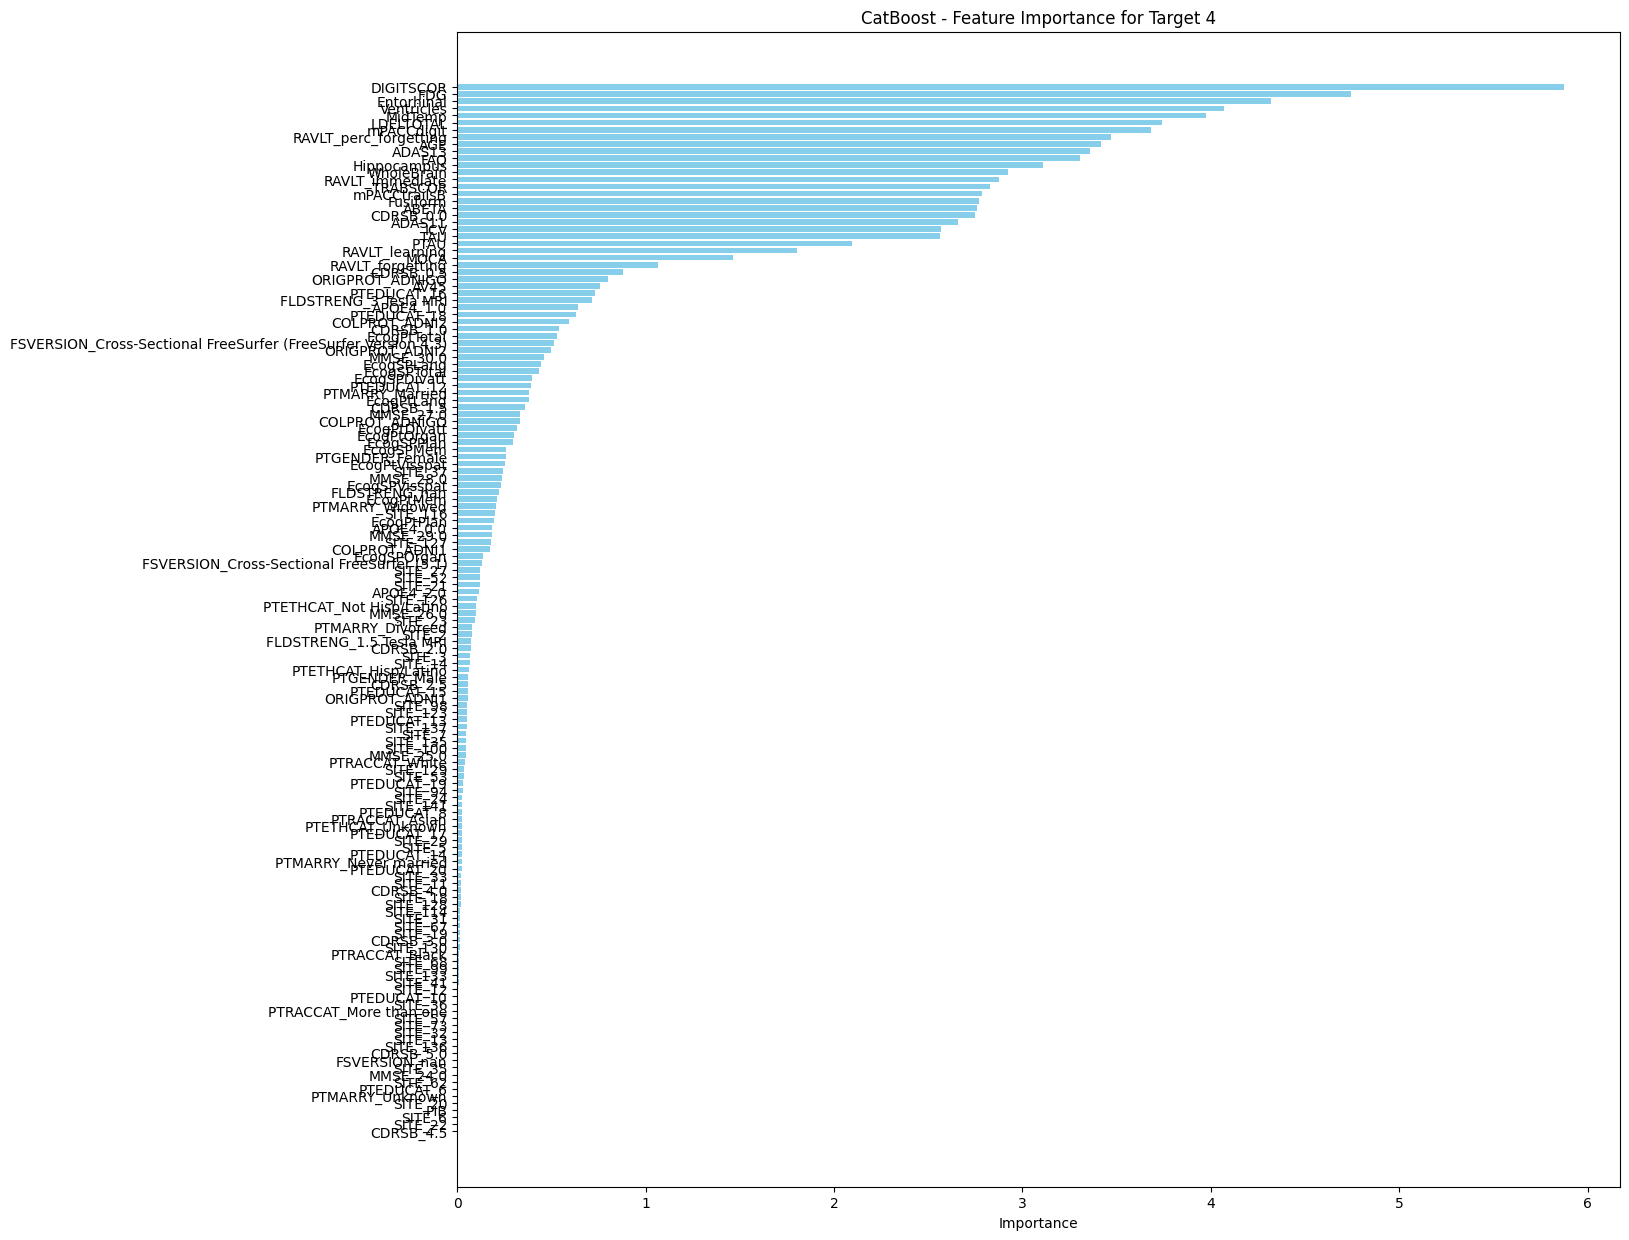

In [11]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Updated to sparse_output


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

classifiers = {
    'XGBoost': MultiOutputClassifier(XGBClassifier(eval_metric='mlogloss', random_state=42)),
    'HistGradientBoosting': MultiOutputClassifier(HistGradientBoostingClassifier(random_state=42)),
    'CatBoost': MultiOutputClassifier(CatBoostClassifier(silent=True, random_state=42))
}


results = {}
models = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    models[name] = pipeline

    y_pred = pipeline.predict(X_test)

    y_pred_decoded = pd.DataFrame()
    y_test_decoded = pd.DataFrame()

    y_pred_decoded = pd.DataFrame()
    y_test_decoded = pd.DataFrame()

    y_pred_decoded = {}
    for i, col in enumerate(y.columns):
        le = label_encoders[col]
        if y_pred.shape[0] == 1:
            y_pred_decoded[col] = le.inverse_transform(y_pred[0, :, i])
        else:
            y_pred_decoded[col] = le.inverse_transform(y_pred[:, i])
    
    y_test_decoded = {}
    for col in y.columns:
        le = label_encoders[col]
        y_test_decoded[col] = le.inverse_transform(y_test[col])


    report = {}
    for col in y.columns:
        report[col] = classification_report(
            y_test_decoded[col], 
            y_pred_decoded[col], 
            zero_division=0,  
            output_dict=True
        )
        print(col)
        print(classification_report(
            y_test_decoded[col], 
            y_pred_decoded[col], 
            zero_division=0,  
            output_dict=False
        ))
        
    for col in y.columns:
        plot_confusion_matrix(y_test_decoded[col], y_pred_decoded[col], le.classes_, f'Confusion Matrix for {name} - {col}')

               
    results[name] = report
    
    plot_feature_importances(models, name)

In [12]:
summary = {}
for model_name, model_results in results.items():
    summary[model_name] = {}
    for target, metrics in model_results.items():
        summary[model_name][f"{target} Accuracy"] = metrics['accuracy']
        summary[model_name][f"{target} Weighted F1-Score"] = metrics['weighted avg']['f1-score']
        summary[model_name][f"{target} Precision"] = metrics['weighted avg']['precision']
        summary[model_name][f"{target} Recall"] = metrics['weighted avg']['recall']


summary_df = pd.DataFrame(summary).T
summary_df

,DX_6M Accuracy,DX_6M Weighted F1-Score,DX_6M Precision,DX_6M Recall,DX_12M Accuracy,DX_12M Weighted F1-Score,DX_12M Precision,DX_12M Recall,DX_24M Accuracy,DX_24M Weighted F1-Score,DX_24M Precision,DX_24M Recall,DX_48M Accuracy,DX_48M Weighted F1-Score,DX_48M Precision,DX_48M Recall,DX_60M Accuracy,DX_60M Weighted F1-Score,DX_60M Precision,DX_60M Recall
XGBoost,0.927711,0.907100,0.892420,0.927711,0.831325,0.820756,0.815539,0.831325,0.686747,0.652373,0.645492,0.686747,0.638554,0.624988,0.639665,0.638554,0.751004,0.703254,0.741794,0.751004
HistGradientBoosting,0.923695,0.903229,0.888928,0.923695,0.843373,0.829536,0.826370,0.843373,0.690763,0.641467,0.636366,0.690763,0.598394,0.579333,0.594270,0.598394,0.742972,0.688491,0.680590,0.742972
CatBoost,0.927711,0.907100,0.892420,0.927711,0.855422,0.840869,0.840715,0.855422,0.690763,0.652827,0.644124,0.690763,0.614458,0.580002,0.593470,0.614458,0.722892,0.659060,0.641566,0.722892
